# Chainer基本例

以下ではChainerのベースとなるコードを置いておく.

以下では下記のパッケージを使用する.
使い方は適宜調べること.

* Numpy
 * 行列演算処理用パッケージ
* Pandas
 * データフレーム・データ処理用パッケージ
* Matplotlib
 * グラフ描画用パッケージ 
* Scikit-learn
 * 機械学習用パッケージ(正規化に使用)
* Chainer
 * 深層学習用パッケージ

In [1]:
import numpy as np
import pandas as pd
import six

import chainer
# from chainer import computational_graph  # need GraphViz
# from chainer import cuda  # For GPU
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
from chainer import serializers


In [2]:
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline

# なんかDeprecationWarning出るかもだけど無視で良いようだ

/Users/kohno/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


## 使用データ

何かしらデータを用意する.

時系列を考慮しない場合など、データ順をシャッフル等したのちに、
教師データとテストデータに分割する必要がある.

ここではダミーデータとして乱数を置いた8変数と0,1,2を順番に教師データとして貼り付けたものを置く.

In [3]:
inputCSV = pd.read_csv('sample.csv')
inputCSV.head(10)

,in0,in1,in2,in3,in4,in5,in6,in7,out
0,0.790158,0.154701,0.554273,0.589591,0.652273,0.809005,0.727239,0.722377,0
1,0.966113,0.082956,0.427091,0.313592,0.036717,0.688759,0.747233,0.084873,1
2,0.744551,0.080415,0.534023,0.874443,0.058886,0.941214,0.234062,0.138623,2
3,0.386799,0.339775,0.758028,0.176749,0.545578,0.645455,0.264393,0.762566,0
4,0.000760,0.339114,0.865157,0.730987,0.061821,0.209777,0.090273,0.183841,1
5,0.497581,0.680770,0.914901,0.990791,0.040909,0.355208,0.881591,0.513112,2
6,0.531146,0.372347,0.246750,0.270516,0.120391,0.682658,0.272929,0.861646,0
7,0.475195,0.512204,0.533743,0.152647,0.070142,0.915401,0.297802,0.617966,1
8,0.841105,0.780319,0.212918,0.535849,0.639757,0.296344,0.653013,0.106019,2
9,0.221653,0.749487,0.411809,0.103275,0.610809,0.310699,0.501801,0.186794,0


In [4]:
# データの並びをシャッフル
calcData = inputCSV.reindex(np.random.permutation(inputCSV.index))
calcData.head(10)

,in0,in1,in2,in3,in4,in5,in6,in7,out
550,0.215933,0.385255,0.033255,0.022961,0.252133,0.563793,0.236852,0.747881,1
311,0.321833,0.204799,0.158407,0.740717,0.984863,0.071780,0.261241,0.545532,2
538,0.066149,0.461709,0.174741,0.389820,0.139790,0.027322,0.109318,0.099765,1
646,0.308434,0.922860,0.828672,0.194588,0.367103,0.241161,0.052246,0.652358,1
201,0.920290,0.109495,0.432154,0.865345,0.268029,0.095433,0.687561,0.653502,0
228,0.268974,0.875602,0.160593,0.535618,0.622466,0.665704,0.248441,0.221968,0
639,0.060529,0.598614,0.560131,0.971657,0.479462,0.178229,0.922058,0.789299,0
277,0.742387,0.468711,0.939128,0.340425,0.105803,0.398152,0.605936,0.373394,1
144,0.695112,0.491648,0.203304,0.717855,0.271292,0.898818,0.835141,0.917030,0
645,0.182982,0.993137,0.507752,0.278938,0.598305,0.574202,0.458036,0.838757,0


In [5]:
# 入力データと教師データに分割
pd_y = calcData['out']
pd_x = calcData.drop(['out'], axis=1)

# numpy配列にデータフレームから変換
x_array = pd_x.as_matrix()
y_array = pd_y.as_matrix()

In [6]:
# 正規化し,float32の型に変換
x_scale = scale(x_array).astype(np.float32)
y_scale = y_array.astype(np.int32)

# サンプルの一部をテストデータ用に分割
N = 550
x_train, x_test = np.split(x_scale, [N])
y_train, y_test = np.split(y_scale, [N])
N_test = y_test.size

print(u'学習データサンプル数：', N)
print(u'テストデータサンプル数：', N_test)

学習データサンプル数： 550
テストデータサンプル数： 99


## Deep learningのモデル定義

以下では暫定的に多層ニューラルネットである4層NNを用いる.

(ここが基本的に変更する場所である.)

なお、活性化関数にReLUを用いる.

In [7]:
# 4層NN
class ClfyMNN(chainer.Chain):
    def __init__(self, n_in, n_units, n_out, train=True):
        super(ClfyMNN, self).__init__(
            l1=L.Linear(n_in, n_units),
            l2=L.Linear(n_units, n_units),
            l3=L.Linear(n_units, n_units),
            l4=L.Linear(n_units, n_out),
        )
        self.train = train
    
    # 全てReLUで実施
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        y = self.l4(h3)
        return y

### バッチサイズや隠れ層のユニット数

In [8]:
batchsize = 100 # 学習時サンプルデータ分割バッチサイズ
n_epoch = 20 # 学習ループ数
n_units = 50 # 隠れ層のユニット数

### 各種設定

In [9]:
n_in = 8 # 入力データの次元
n_out = 3 # 分類だと分類数を定義

model = L.Classifier(ClfyMNN(n_in, n_units, n_out))
# cuda.get_device(0).use() # For GPU
# model.to_gpu() # For GPU
# xp = cuda.cupy # For GPU
xp = np  # For CPU

In [10]:
# 最適化手法の指定
optimizer = optimizers.Adam() # とりあえず無難なAdam
optimizer.setup(model)

## 学習の実施

In [11]:
out_train_accuracy = []
out_test_accuracy = []
out_train_loss = []
out_test_loss = []

print_epoch = 5 # 途中経過出力タイミング

# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    if epoch % print_epoch == 0:
        print('epoch', epoch)
        
    # training step
    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0

    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]]))
        t = chainer.Variable(xp.asarray(y_train[perm[i:i + batchsize]]))
        
        # Pass loss function
        optimizer.update(model, x, t)
        
        # モデルのグラフ出力(要GraphViz)
        #if epoch == 1 and i == 0:
        #    with open('graph.dot', 'w') as o:
        #        g = computational_graph.build_computational_graph(
        #            (model.loss, ))
        #        o.write(g.dump())
        #    print('graph generated')
        
        sum_loss += float(model.loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
    
    out_train_accuracy.append(sum_accuracy / N)
    out_train_loss.append(sum_loss / N)
    if epoch % print_epoch == 0:
        print('train mean loss={}, accuracy={}'.format(
            sum_loss / N, sum_accuracy / N))
    
    # Evaluation step
    sum_accuracy = 0
    sum_loss = 0
    for i in six.moves.range(0, N_test, batchsize):
        x = chainer.Variable(xp.asarray(x_test[i:i + batchsize]),
                            volatile='on') # パラメータの更新をさせないようにvolatile='on'に
        t = chainer.Variable(xp.asarray(y_test[i:i + batchsize]),
                            volatile='on')
        loss = model(x, t)
        sum_loss += float(loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
        
    out_test_accuracy.append(sum_accuracy / N_test)
    out_test_loss.append(sum_loss / N_test)
    if epoch % print_epoch == 0:
        print('test mean loss={}, accuracy={}'.format(
            sum_loss / N_test, sum_accuracy / N_test))

epoch 5
train mean loss=1.061263918876648, accuracy=0.42000000314279035
test mean loss=1.107223629951477, accuracy=0.3232323229312897
epoch 10
train mean loss=1.0240410674702038, accuracy=0.4709090942686254
test mean loss=1.1219933032989502, accuracy=0.3636363744735718
epoch 15
train mean loss=0.9914211143146862, accuracy=0.5090909058397467
test mean loss=1.1356171369552612, accuracy=0.35353535413742065
epoch 20
train mean loss=0.9584353241053495, accuracy=0.5400000052018599
test mean loss=1.1542686223983765, accuracy=0.34343433380126953


## 学習の結果

epochの進捗とそれに合わせた的中率をプロット.

過学習になっていないかtestデータの的中率を見た方が良い.

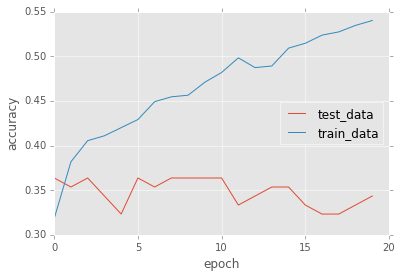

In [12]:
plt.style.use('ggplot') # ggplot風出力

plt.plot(out_test_accuracy, label='test_data')
plt.plot(out_train_accuracy, label='train_data')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc = 5) # 凡例の場所指定

plt.show()

## モデルの予測値について

In [13]:
# 学習されたパラメータへもう一度テストデータを通す(ここはもっといいやり方ありそう)
out_h1 = F.relu(model.predictor.l1(chainer.Variable(xp.asarray(x_test))))
out_h2 = F.relu(model.predictor.l2(out_h1))
out_h3 = F.relu(model.predictor.l3(out_h2))
estimate_y = model.predictor.l4(out_h3)

In [14]:
#t = cuda.to_cpu(estimate_y.data) # For GPU
t = estimate_y.data # arrayとしてデータを取り出す

# 一番大きいargmentを推定値とする
est = []
for idx in range(N_test):
    est.append(np.argmax(t[idx,:]))
pd_est = pd.DataFrame(est)
pd_est.columns = ['est']
pd_est.head(5)

,est
0,1
1,2
2,2
3,2
4,2


In [15]:
# 元々のデータをくっつけてみる
pd_ans = pd_y.reset_index(drop=True) # シャッフルしてるのでindex振り直しておく
pd_ans.columns = ['ans']

pd_compare = pd.concat([pd_est, pd_ans], axis=1)
pd_compare['compare'] = np.where(pd_compare['est'] == pd_compare['out'], 1, 0) # 当たってたら1、外れてたら0
pd_compare.head(20)

,est,out,compare
0,1,1,1
1,2,2,1
2,2,1,0
3,2,1,0
4,2,0,0
5,0,0,1
6,2,0,0
7,0,1,0
8,2,0,0
9,2,0,0


In [16]:
N_match = pd_compare['compare'].sum(axis=0)
Per_match = 100 * N_match / N_test
print(u'的中率：{} %'.format(Per_match))

的中率：32.323232323232325 %
